<a href="https://colab.research.google.com/github/dbonafilia/train_cloud_segmentation/blob/master/BasicTrainingFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First mount the Google Drive to access training data

In [1]:
bucket_name = 'cloud-segmentation-dataset'
export GCSFUSE_REPO=gcsfuse-`lsb_release -c -s`
sudo echo "deb http://packages.cloud.google.com/apt $GCSFUSE_REPO main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
sudo curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
sudo apt -qq update
sudo apt -qq install gcsfuse
gcsfuse cloud-segmentation-dataset files

SyntaxError: invalid syntax (<ipython-input-1-04a82b6b0d29>, line 2)

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [2]:
import multiprocessing
import platform
multiprocessing.cpu_count()

16

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
print(tf.__version__)

2.0.0


Import necessary packages

In [5]:
from skimage import io
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split

Set up dataset file names

In [6]:
SPARCS_DATA_DIR = "/home/jupyter/files"
SPARCS_FILES = [os.path.join(SPARCS_DATA_DIR, f) for f in os.listdir(SPARCS_DATA_DIR)]
MASK_FILES = sorted([f for f in SPARCS_FILES if ("_mask.tif" in f and "._" not in f)])
IMAGERY_FILES = sorted([f for f in SPARCS_FILES if ("_data.tif" in f and "._" not in f)])

Load imagery and masks into memory

In [7]:
imagery = np.stack([io.imread(f) for f in IMAGERY_FILES])
masks = np.stack([io.imread(f) for f in MASK_FILES])

Split data into train, test, and validation

In [8]:
data_train, data_test, labels_train, labels_test = train_test_split(imagery, masks, test_size=0.30)
train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train))
#data_validation, data_test, labels_validation, labels_test = train_test_split(data_test, labels_test, test_size=0.50)
valid_dataset = tf.data.Dataset.from_tensor_slices((data_test, labels_test))

Set up Data Augmentation stuff

In [9]:
import random
IMG_HEIGHT = 256
IMG_WIDTH = 256

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 65535.0
  return input_image, tf.cast(input_mask, tf.float32)

def random_crop(input_image, input_mask):
  stacked_image = tf.concat([input_image, input_mask], 2)
  cropped_stacked_image = tf.image.random_crop(
      stacked_image, size=[IMG_HEIGHT, IMG_WIDTH, 11])
  return cropped_stacked_image[:,:,:10], cropped_stacked_image[:,:,10:]


@tf.function
def load_image_train(image, mask):
  input_image, input_mask = normalize(image, mask)
  input_mask = tf.expand_dims(input_mask,2)
  input_image, input_mask = random_crop(input_image, input_mask)
  input_image = tf.image.random_brightness(input_image, .25)
  input_image = tf.image.random_contrast(input_image, lower=.85,upper=1.15)
  if np.random.uniform() > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  if np.random.uniform() > 0.5:
    input_image = tf.image.flip_up_down(input_image)
    input_mask = tf.image.flip_up_down(input_mask)
  input_mask = tf.keras.backend.one_hot(
    tf.squeeze(tf.cast(input_mask,tf.int32)),7)
  return input_image, input_mask

def load_image_test(image, mask):
  input_image, input_mask = normalize(image, mask)
  input_mask = tf.expand_dims(input_mask,2)
  input_image, input_mask = random_crop(input_image, input_mask)
  input_mask = tf.keras.backend.one_hot(
    tf.squeeze(tf.cast(input_mask,tf.int32)),7)

  return input_image, input_mask

In [10]:
#train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#valid_dataset = valid_dataset.map(load_image_test)

In [11]:
dataset_iter = iter(train_dataset)

In [12]:
import sys
import matplotlib.pyplot as plt
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if display_list[i].shape[2] == 10:
      im = display_list[i][:,:,2:5]
    else:
      im = create_mask(tf.expand_dims(display_list[i], 0))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(im))
    plt.axis('off')
  plt.show()
#sample_image, sample_mask = next(dataset_iter)
#display([sample_image, sample_mask])

In [13]:
BATCH_SIZE = 16
BUFFER_SIZE = 128
#train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#valid_dataset = valid_dataset.map(load_image_test)
train_dataset = train_dataset.repeat().shuffle(BUFFER_SIZE).map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.repeat().map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_iter = iter(train_dataset)

In [14]:
import time
t = time.time()
print(next(dataset_iter)[1].shape)
print(t - time.time())

(16, 256, 256, 7)
-2.718844175338745


Create DICE loss function

In [15]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-7))

def dice_coef_multilabel(y_true, y_pred, numLabels=7):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    
    return dice/numLabels

Create a U-Net model following Tensorflow Segmentation Example


In [16]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 10], include_top=False, weights=None)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = True

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
    upsample(32, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 10])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

/usr/local/lib/python3.5/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 10 input channels.
  str(input_shape[-1]) + ' input channels.')


In [17]:
model = unet_model(7)

In [18]:
for layer in model.layers:
  if "Model" in str(type(layer)):
    for l in layer.layers:
      if (isinstance(l,tf.keras.layers.Conv2D) or isinstance(l,tf.keras.layers.Conv2DTranspose)) or isinstance(l, tf.keras.layers.DepthwiseConv2D):
        l.add_loss(lambda: tf.keras.regularizers.l2(0.0001)(l.depthwise_kernel if hasattr(l, "depthwise_kernel") else l.kernel))
  if (isinstance(layer,tf.keras.layers.Conv2D) or isinstance(layer,tf.keras.layers.Conv2DTranspose)) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
    layer.add_loss(lambda: tf.keras.regularizers.l2(0.0001)(layer.depthwise_kernel if hasattr(l, "depthwise_kernel") else layer.kernel))
  if isinstance(layer, tf.keras.layers.DepthwiseConv2D):
    layer.add_loss(lambda: tf.keras.regularizers.l2(0.0001)(layer.depthwise_kernel))



In [19]:
#model.load_weights("drive/My Drive/decent_starting_segmentation_model_new.ckpt")
#sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=.9, nesterov=True)
schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    .00005,
    2000,
    .0025,
    power=1)
adam = tf.keras.optimizers.Adam(learning_rate=schedule)
model.compile(optimizer=adam, loss=dice_coef_multilabel,
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=7)])

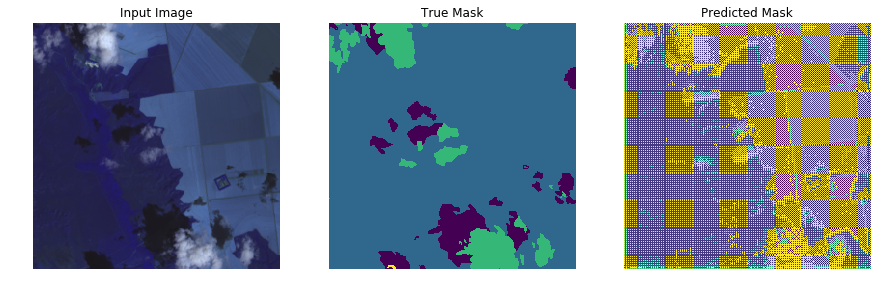

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict((image))
      im = tf.keras.backend.one_hot(
        tf.squeeze(create_mask(pred_mask)),
        7
      )
      display([image[0], mask[0], im])
show_predictions(train_dataset)

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    global t0
    clear_output(wait=True)
    print ('\Time for epoch {}\n'.format(t0-time.time()))
    t0 = time.time()
    show_predictions(valid_dataset)
    show_predictions(train_dataset)   
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [22]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.iou = []
        self.val_iou = []

        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.iou.append(logs.get('mean_io_u'))
        self.val_iou.append(logs.get('val_mean_io_u'))
        self.i += 1
        plt.plot(self.x, self.loss, label="loss")
        plt.plot(self.x, self.val_loss, label="val_loss")
        plt.plot(self.x, self.iou, label="miou")
        plt.plot(self.x, self.val_iou, label="val_miou")

        plt.legend()
        plt.show();

In [23]:
#valid_dataset = valid_dataset.repeat()

\Time for epoch -129.0202829837799



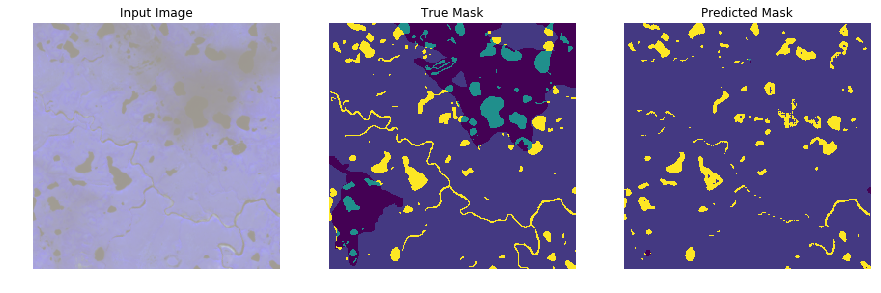

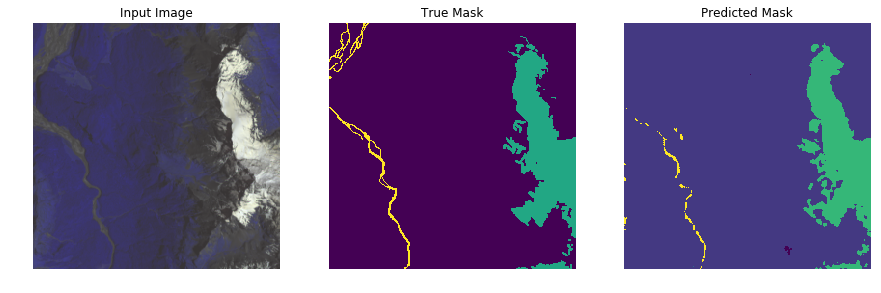


Sample Prediction after epoch 57



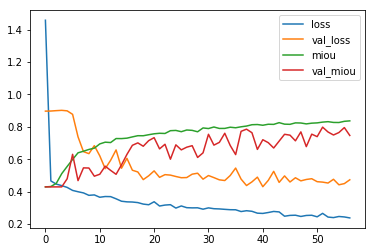

400/400 [==============================] - 128s 321ms/step - loss: 0.2368 - accuracy: 0.9388 - mean_io_u: 0.8367 - val_loss: 0.4724 - val_accuracy: 0.8540 - val_mean_io_u: 0.7465
Epoch 58/500
229/400 [================>.............] - ETA: 45s - loss: 0.2450 - accuracy: 0.9373 - mean_io_u: 0.8403

In [ ]:
from IPython.display import clear_output
import time
from datetime import datetime
t0 = time.time()
EPOCHS = 500
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
#logdir = "/home/jupyter/files/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
ti = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = "gs://cloud-segmentation-dataset/logs/" + ti
print(logdir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
checkpoint_path = "gs://cloud-segmentation-dataset/checkpoints/{}".format(ti) + "weights.{epoch:02d}-{val_loss:.2f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 period=10)

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=400,
                          validation_steps=40,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), MetricsCallback(), tensorboard_callback, cp_callback])

In [ ]:
import time
@tf.function
def train(model, dataset, optimizer):
  i = 0
  t0 = time.time()
  for x, y in dataset_iter:
    print("got batch")
    print(time.time() - t0)    
    i += 1
    t0 = time.time()
    with tf.GradientTape() as tape:
      prediction = model(x)
      print("made prediction")
      print(time.time() - t0)    
      loss = tf.keras.losses.categorical_crossentropy(prediction, y)
      print("calculated loss")
      print(time.time() - t0)    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    print(time.time() - t0)
    t0 = time.time()
    t0 = time.time()
    if i == 10:
        break
    


In [ ]:
tf.keras.backend.clear_session()
train(model, train_dataset, adam)

In [ ]:
print(os.cpu_count())